## Rolling 97.5% ES calculation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Parameters ---
WINDOW = 252
ES_LEVEL = 97.5
ES_ALPHA = 1 - ES_LEVEL / 100

# --- Load Data ---
DATA_DIR = "data"
portfolio_returns_path = os.path.join(DATA_DIR, "portfolio_log_returns.csv")
# Load as a DataFrame initially
returns_df = pd.read_csv(portfolio_returns_path, index_col='Date', parse_dates=True)
# Select the Series for calculations
returns_series = returns_df['EqualWeightPortfolio']
print("Successfully loaded portfolio returns.")

Successfully loaded portfolio returns.


### Historical ES

Calculating rolling Historical ES (97.5%)...

✅ Historical ES calculation complete.
Preview:
Date
2008-04-10   -0.025539
2008-04-11   -0.027030
2008-04-14   -0.027030
2008-04-15   -0.027030
2008-04-16   -0.027030
Name: HistES_97.5, dtype: float64


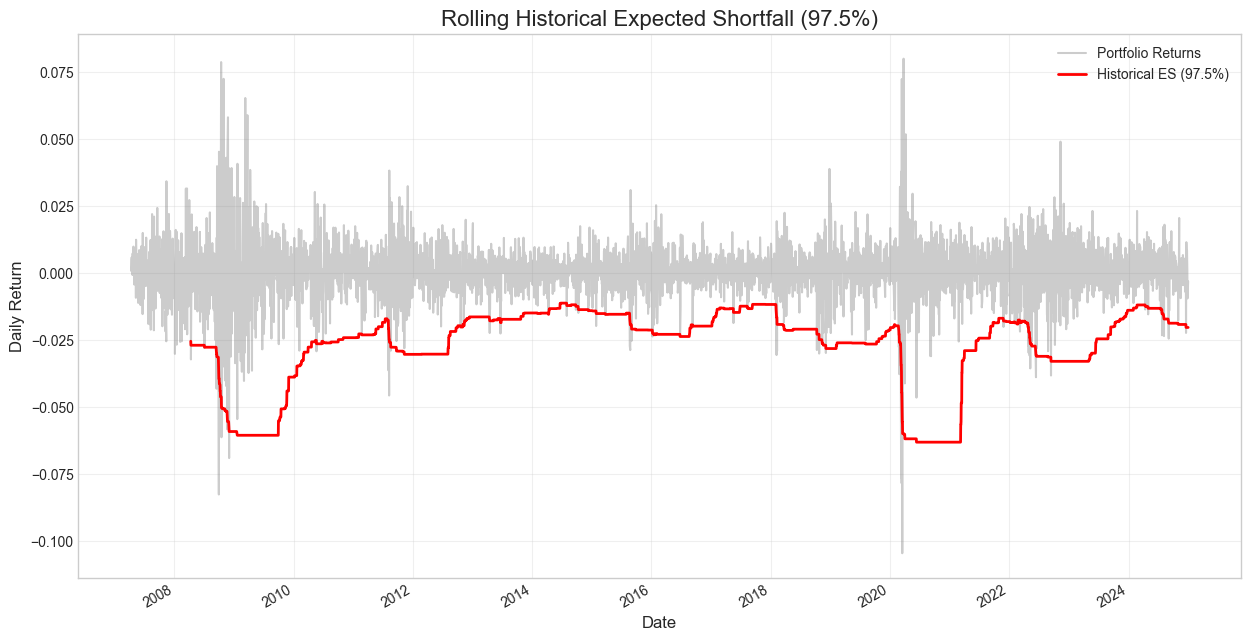

In [2]:
# --- Calculate Rolling Historical ES ---
print("Calculating rolling Historical ES (97.5%)...")
rolling_returns_series = returns_series.rolling(window=WINDOW)

# Calculate the rolling 97.5% VaR (needed as the threshold for ES)
# This will be a Series
historical_var_975_series = returns_series.rolling(window=WINDOW).quantile(ES_ALPHA)

# --- CORRECTED LAMBDA FUNCTION ---
# x is now a Series (the window), compare it directly to the scalar VaR
historical_es_975 = rolling_returns_series.apply(
    lambda x: x[x < historical_var_975_series.loc[x.index[-1]]].mean(),
    raw=False # Use raw=False for correct indexing with .loc
).rename('HistES_97.5') # Rename the resulting Series directly

# Drop initial NaNs
historical_es_975.dropna(inplace=True)

print("\n✅ Historical ES calculation complete.")
print("Preview:")
print(historical_es_975.head())

# --- Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

returns_series.plot(ax=ax, color='gray', alpha=0.4, label='Portfolio Returns')
historical_es_975.plot(ax=ax, color='red', linewidth=2, label='Historical ES (97.5%)') # Plot Series directly

ax.set_title('Rolling Historical Expected Shortfall (97.5%)', fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.grid(True, alpha=0.3)
plt.show()

hist_es = historical_es_975 # Save the resulting Series

---

### Parametric t-distribution ES

Calculating rolling Parametric ES (t-Dist) (97.5%)...


100%|██████████| 4211/4211 [01:50<00:00, 38.04it/s]



✅ Parametric ES (t-Dist) calculation complete.
Preview:
Date
2008-04-10   -0.027714
2008-04-11   -0.028725
2008-04-14   -0.028629
2008-04-15   -0.028654
2008-04-16   -0.028669
Name: ParamT_ES_97.5, dtype: float64


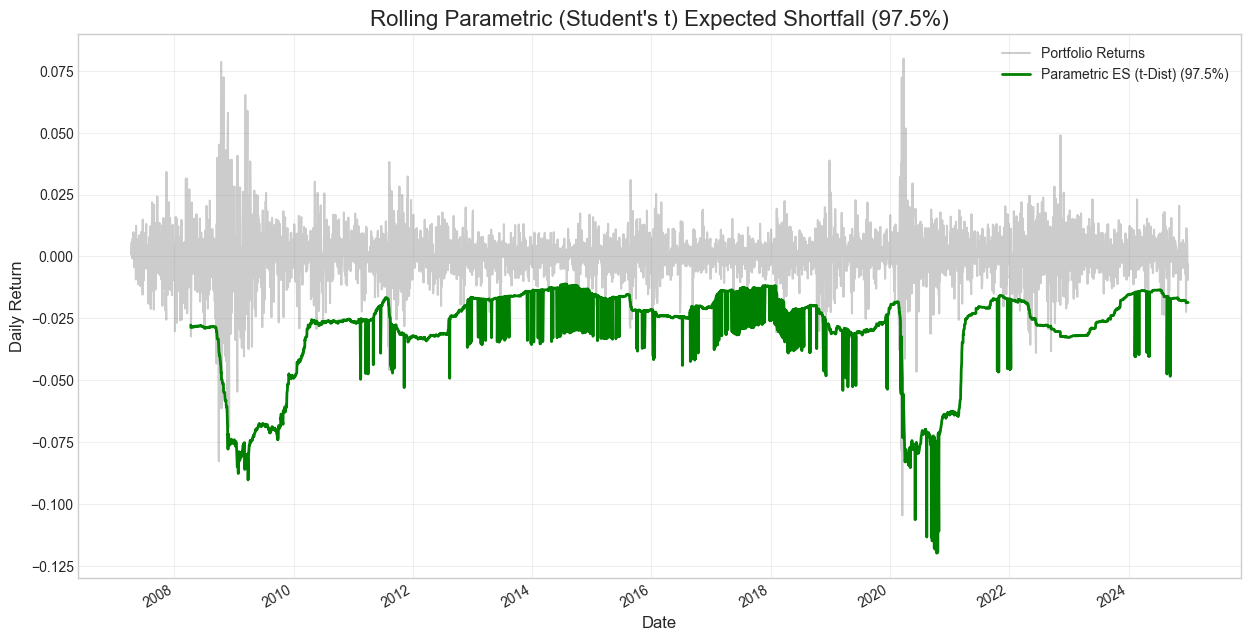

In [3]:
from scipy.stats import t
from tqdm import tqdm

# --- Define Helper Function for t-Distribution ES ---
def get_t_es(returns_window, alpha=ES_ALPHA):
    """Fits a t-distribution and calculates ES."""
    try:
        # Fit the t-distribution to the window of returns
        params = t.fit(returns_window)
        df, loc, scale = params
        
        # Calculate ES using the fitted parameters
        # Get the VaR quantile needed for the ES formula
        t_stat_at_alpha = t.ppf(alpha, df)
        
        # Standard formula for ES of a t-distribution
        es_975 = loc - scale * ( (df + t_stat_at_alpha**2)/(df - 1) ) * ( t.pdf(t_stat_at_alpha, df) / alpha )
        
        # Add safety check for extreme low df values
        if df <= 1:
            return np.nan # ES is not defined for df <= 1
            
        return es_975
    except Exception:
        # Fallback if fitting fails (e.g., use historical ES for the window)
        var_thresh = np.percentile(returns_window, alpha * 100)
        return np.mean(returns_window[returns_window < var_thresh])


# --- Calculate Rolling Parametric ES (t-Distribution) ---
print("Calculating rolling Parametric ES (t-Dist) (97.5%)...")
returns_np = returns_series.to_numpy()
results_list = []
result_index = returns_series.index[WINDOW-1:]

for i in tqdm(range(len(returns_np) - WINDOW + 1)):
    window = returns_np[i : i + WINDOW]
    results_list.append(get_t_es(window))

# Convert the list of results into a DataFrame
param_t_es_975 = pd.Series(results_list, index=result_index, name='ParamT_ES_97.5')

# Drop any NaNs that might have occurred from fallbacks or low df
param_t_es_975.dropna(inplace=True)

print("\n✅ Parametric ES (t-Dist) calculation complete.")
print("Preview:")
print(param_t_es_975.head())

# --- Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

returns_series.plot(ax=ax, color='gray', alpha=0.4, label='Portfolio Returns')
param_t_es_975.plot(ax=ax, color='green', linewidth=2, label='Parametric ES (t-Dist) (97.5%)')

ax.set_title("Rolling Parametric (Student's t) Expected Shortfall (97.5%)", fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.grid(True, alpha=0.3)
plt.show()

param_t_es = param_t_es_975 

---

### GJR GARCH ES

✅ Setup complete. Portfolio returns are loaded.

Calculating rolling GJR-GARCH ES (97.5%)...


100%|██████████| 4210/4210 [01:14<00:00, 56.42it/s]



✅ GJR-GARCH ES calculation complete.
Preview:
2008-04-11   -0.024504
2008-04-14   -0.040598
2008-04-15   -0.039035
2008-04-16   -0.037317
2008-04-17   -0.036118
Name: GJR_ES_97.5, dtype: float64


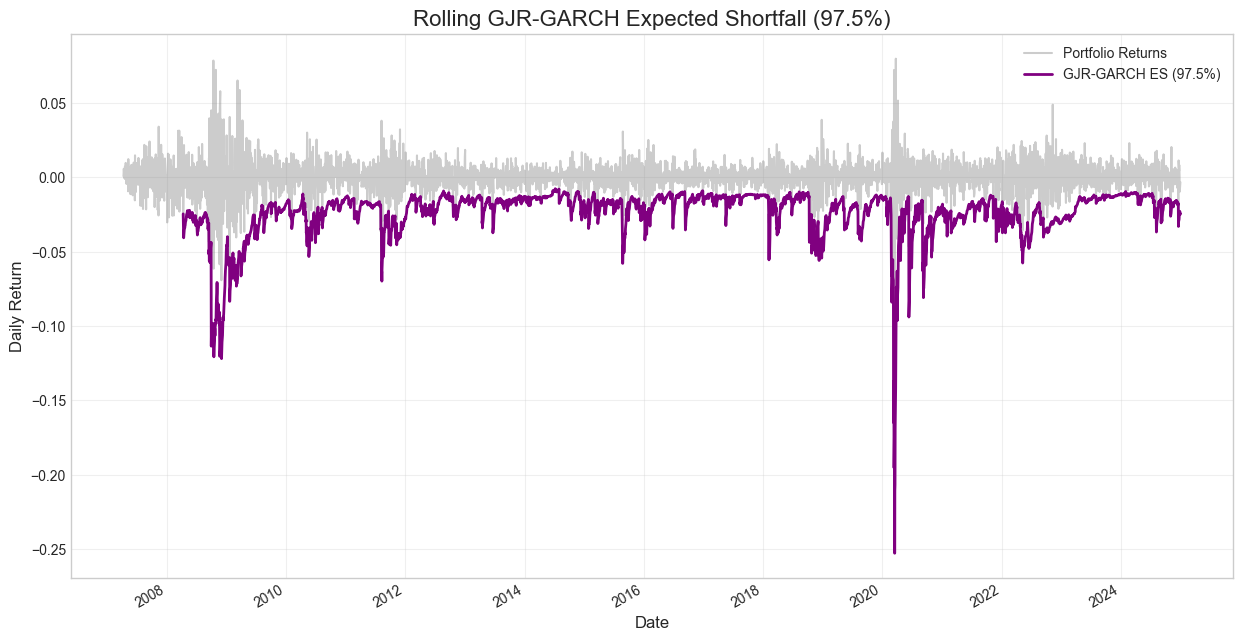

In [4]:
import pandas as pd
import numpy as np
import os
from arch import arch_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# --- 1. Setup ---
DATA_DIR = "data"
WINDOW = 252
ES_LEVEL = 97.5
ES_ALPHA = 1 - ES_LEVEL / 100

# Load portfolio returns
returns_df = pd.read_csv(
    os.path.join(DATA_DIR, "portfolio_log_returns.csv"),
    index_col='Date',
    parse_dates=True
)
portfolio_returns = returns_df['EqualWeightPortfolio']
print("✅ Setup complete. Portfolio returns are loaded.")

# --- 2. GJR-GARCH Model Fitting Function ---
# (Using your robust fit_gjr_garch_model function)
def fit_gjr_garch_model(returns_window):
    """Fits a GJR-GARCH(1,1) model with a Student's t-distribution."""
    try:
        model = arch_model(
            returns_window * 100,
            vol='Garch', p=1, o=1, q=1,
            mean='Constant', dist='t'
        )
        fit = model.fit(disp='off')
        if not fit.convergence_flag:
            return fit, True
        else:
            return None, False
    except Exception:
        return None, False

# --- 3. Define Helper Function for FHS ES Calculation ---
def calculate_fhs_es(window_returns, garch_fit_obj, alpha=ES_ALPHA):
    """Calculates ES using GARCH fit and empirical residuals."""
    if garch_fit_obj is None: # Handle fallback case
        var_thresh = window_returns.quantile(alpha)
        # Ensure there are returns below threshold before calculating mean
        tail_returns = window_returns[window_returns < var_thresh]
        return tail_returns.mean() if not tail_returns.empty else np.nan

    # Forecast mean and volatility
    forecast = garch_fit_obj.forecast(horizon=1)
    cond_mean = forecast.mean.iloc[-1, 0] / 100
    cond_vol = np.sqrt(forecast.variance.iloc[-1, 0]) / 100

    # Get standardized residuals
    std_resid = gjr_garch_fit.resid / gjr_garch_fit.conditional_volatility
    
    # Calculate the VaR quantile from the residuals
    var_quantile_resid = std_resid.quantile(alpha)
    
    # Calculate ES based on residuals worse than the VaR quantile
    tail_residuals = std_resid[std_resid < var_quantile_resid]
    es_resid = tail_residuals.mean() if not tail_residuals.empty else np.nan
    
    # Final ES = E[ret] + sqrt(E[vol]) * ES_of_std_resid
    es_975 = cond_mean + cond_vol * es_resid
    return es_975

# --- 4. Calculate Rolling GJR-GARCH ES ---
gjr_es_results = []
gjr_dates = []
print("\nCalculating rolling GJR-GARCH ES (97.5%)...")
for i in tqdm(range(WINDOW, len(portfolio_returns))):
    window = portfolio_returns.iloc[i-WINDOW:i]
    current_date = portfolio_returns.index[i]
    
    gjr_garch_fit, success = fit_gjr_garch_model(window)
    
    if success:
        es_val = calculate_fhs_es(window, gjr_garch_fit, alpha=ES_ALPHA)
    else:
        # Fallback to historical ES if GARCH fails
        var_thresh = window.quantile(ES_ALPHA)
        tail_returns = window[window < var_thresh]
        es_val = tail_returns.mean() if not tail_returns.empty else np.nan

    gjr_es_results.append(es_val)
    gjr_dates.append(current_date)

# Create the final Series
gjr_es_975 = pd.Series(gjr_es_results, index=gjr_dates, name='GJR_ES_97.5')

# Drop any NaNs that might have occurred
gjr_es_975.dropna(inplace=True)

print("\n✅ GJR-GARCH ES calculation complete.")
print("Preview:")
print(gjr_es_975.head())

# --- 5. Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

portfolio_returns.plot(ax=ax, color='gray', alpha=0.4, label='Portfolio Returns')
gjr_es_975.plot(ax=ax, color='purple', linewidth=2, label='GJR-GARCH ES (97.5%)')

ax.set_title("Rolling GJR-GARCH Expected Shortfall (97.5%)", fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.grid(True, alpha=0.3)
plt.show()

gjr_es = gjr_es_975 # Save the resulting Series

---

### EVT ES

In [5]:
import pandas as pd
import numpy as np
import os
from scipy.stats import genpareto

# --- 1. Setup ---
DATA_DIR = "data"
WINDOW = 252 # Still needed for context, though not used in static calculation
ES_LEVEL = 97.5
ES_ALPHA = 1 - ES_LEVEL / 100

# Load portfolio returns
returns_df = pd.read_csv(
    os.path.join(DATA_DIR, "portfolio_log_returns.csv"),
    index_col='Date',
    parse_dates=True
)
portfolio_returns = returns_df['EqualWeightPortfolio']
print("Successfully loaded portfolio returns.")

# --- 2. Fit the GPD (Using Full History) ---
# We analyze losses from the entire history
losses = -portfolio_returns.dropna()

# Select threshold (95th percentile)
threshold = losses.quantile(0.95)
exceedances = losses[losses > threshold]

# Check for enough data points
if len(exceedances) < 10:
    print("Warning: Not enough exceedances in the full history for a stable EVT fit.")
    evt_es_975_static = np.nan # Cannot calculate
else:
    # Fit the GPD to the exceedances (relative to threshold)
    shape, loc, scale = genpareto.fit(exceedances - threshold, floc=0)

    print(f"\n--- EVT-GPD Model Fit (Full History at {threshold*100:.2f}% threshold) ---")
    print(f"Estimated Shape parameter (xi): {shape:.4f}")
    print(f"Estimated Scale parameter (beta): {scale:.4f}")

    # --- 3. Calculate Static EVT ES (97.5%) ---
    n = len(losses)
    n_u = len(exceedances)

    # Calculate the 97.5% VaR threshold first
    var_975_for_es = threshold + (scale / shape) * ((n / n_u * (1 - (1 - ES_ALPHA)))**(-shape) - 1)
    
    # Then, calculate ES using the standard formula
    evt_es_975_static_positive = (var_975_for_es + scale - shape * threshold) / (1 - shape)

    # Convert to a negative number to represent loss
    evt_es_975_static = -evt_es_975_static_positive

    print("\n✅ Static EVT ES calculation complete.")
    print(f"Static 97.5% ES Estimate (EVT): {evt_es_975_static*100:.4f}%")

# Store the result for later use in Phase 7
evt_es_static = evt_es_975_static # Save the scalar value

Successfully loaded portfolio returns.

--- EVT-GPD Model Fit (Full History at 1.58% threshold) ---
Estimated Shape parameter (xi): 0.1571
Estimated Scale parameter (beta): 0.0085

✅ Static EVT ES calculation complete.
Static 97.5% ES Estimate (EVT): -3.3256%


---

### Hybrid HMM ES

In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

# --- 1. Setup and Feature Engineering ---
DATA_DIR = "data"
returns_df = pd.read_csv(
    os.path.join(DATA_DIR, "portfolio_log_returns.csv"),
    index_col='Date',
    parse_dates=True
)
portfolio_returns = returns_df['EqualWeightPortfolio']

# --- FEATURE ENGINEERING: Create a richer feature set ---
# We'll use returns and 1-month rolling volatility as features
features = pd.DataFrame(index=portfolio_returns.index)
features['returns'] = portfolio_returns
features['volatility'] = portfolio_returns.rolling(22).std()
features.dropna(inplace=True)

# Reshape data for HMM
hmm_features = features.values

print("✅ Feature engineering complete. Using returns and volatility.")

✅ Feature engineering complete. Using returns and volatility.



Finding the optimal number of regimes using BIC...


Model is not converging.  Current: 35974.25663001066 is not greater than 35974.34976030098. Delta is -0.09313029031909537


Optimal number of regimes found: 4


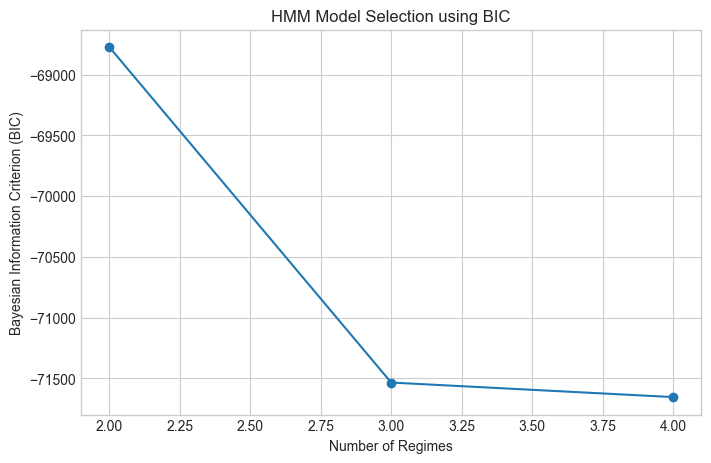

Model is not converging.  Current: 35974.256630009884 is not greater than 35974.34976030124. Delta is -0.09313029135228135



✅ Final HMM model fitting complete.

High-volatility regime identified as state: 3

--- Regime 0 ---
Mean Return: -0.00002
Mean Volatility: 0.01158

--- Regime 1 ---
Mean Return: -0.00063
Mean Volatility: 0.02005

--- Regime 2 ---
Mean Return: 0.00084
Mean Volatility: 0.00594

--- Regime 3 ---
Mean Return: -0.00341
Mean Volatility: 0.03684


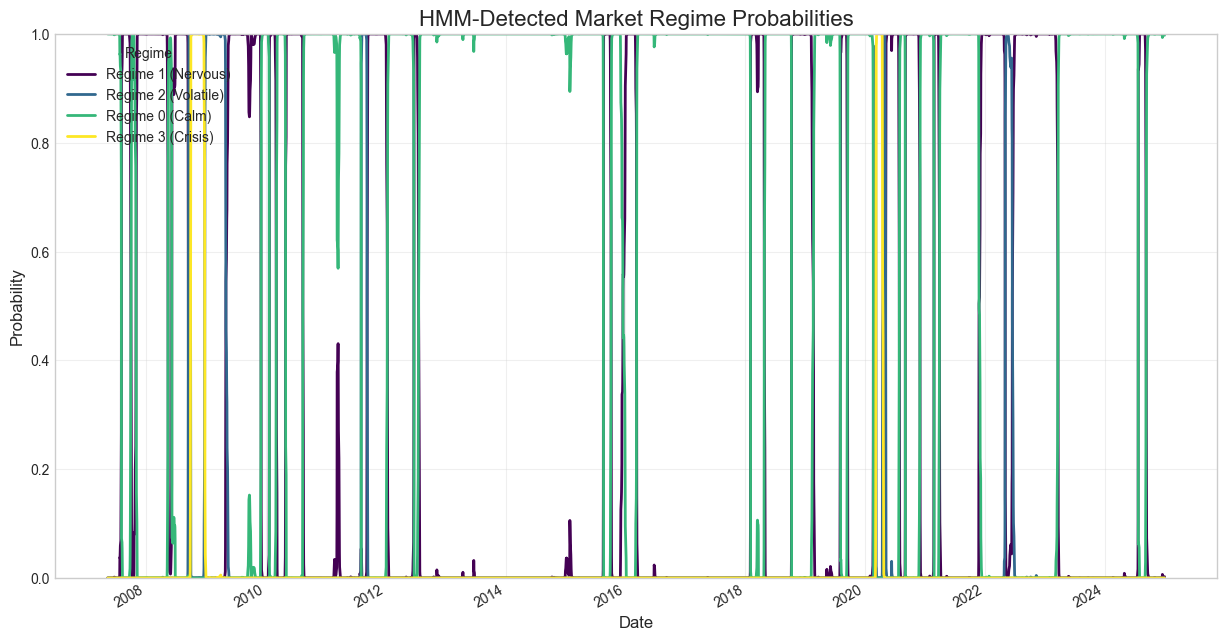

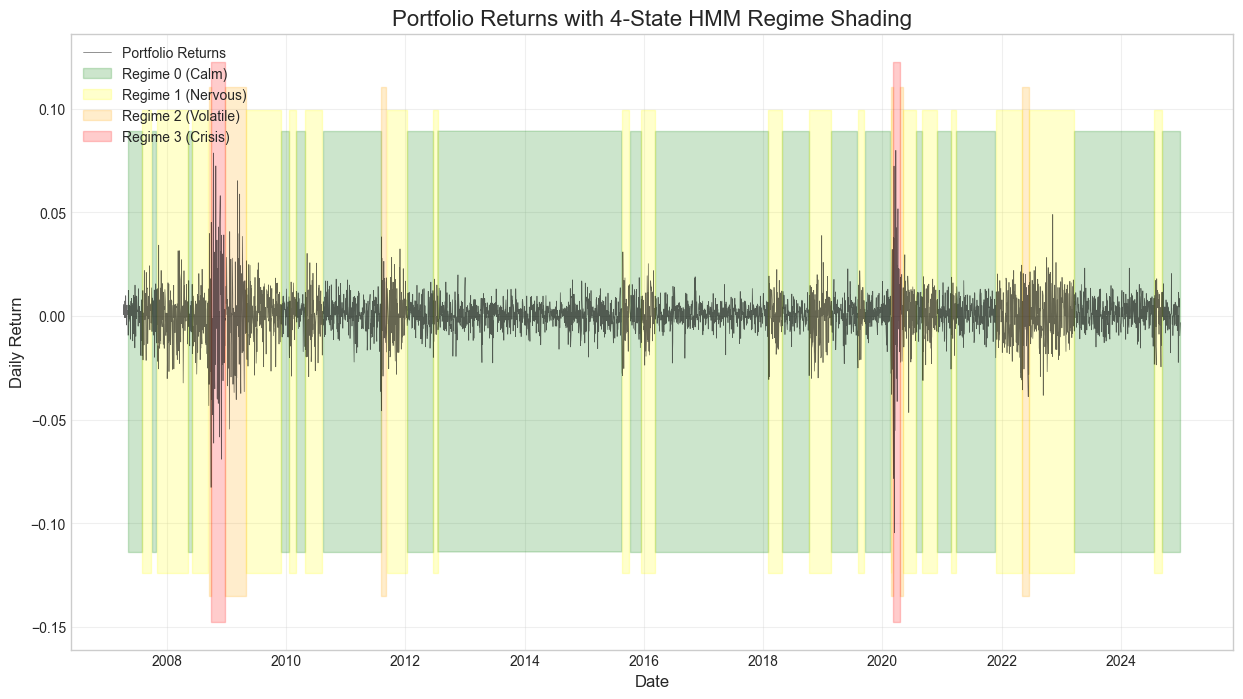

✅ HMM parameters extracted.
Calmest Regime Volatility: 0.0059
Crisis Regime Volatility: 0.0368

✅ Daily stress factor calculated.
Preview of the stress factor:
Date
2007-05-11    0.000000e+00
2007-05-14    9.647933e-07
2007-05-15    9.895289e-07
2007-05-16    8.836307e-07
2007-05-17    9.529268e-07
Name: StressFactor, dtype: float64


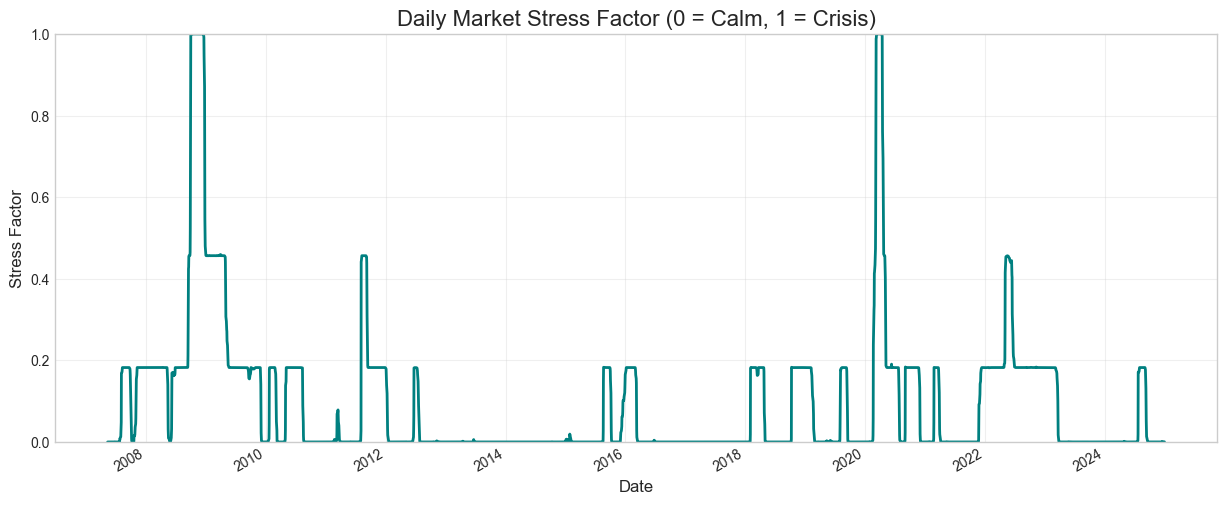

In [11]:
# --- 2. Model Selection using BIC ---
# We will test HMMs with 2, 3, and 4 states (regimes)
possible_states = range(2, 5)
bic_scores = []

print("\nFinding the optimal number of regimes using BIC...")
for n_states in possible_states:
    model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
    model.fit(hmm_features)
    bic_scores.append(model.bic(hmm_features))

# Select the model with the lowest BIC score
optimal_states = possible_states[np.argmin(bic_scores)]
print(f"Optimal number of regimes found: {optimal_states}")

# Plot the BIC scores
plt.figure(figsize=(8, 5))
plt.plot(possible_states, bic_scores, 'o-')
plt.title('HMM Model Selection using BIC')
plt.xlabel('Number of Regimes')
plt.ylabel('Bayesian Information Criterion (BIC)')
plt.show()


# --- 3. Fit the Final, Optimal HMM Model ---
final_hmm_model = GaussianHMM(n_components=optimal_states, covariance_type="full", n_iter=1000, random_state=42)
final_hmm_model.fit(hmm_features)
print("\n✅ Final HMM model fitting complete.")

# --- 4. Identify and Analyze the Regimes ---
# Identify the high-volatility regime by finding the state with the highest volatility component
volatilities = [np.sqrt(cov[1, 1]) for cov in final_hmm_model.covars_]
high_vol_regime = np.argmax(volatilities)
print(f"\nHigh-volatility regime identified as state: {high_vol_regime}")

for i in range(optimal_states):
    print(f"\n--- Regime {i} ---")
    print(f"Mean Return: {final_hmm_model.means_[i][0]:.5f}")
    print(f"Mean Volatility: {final_hmm_model.means_[i][1]:.5f}")

# --- 5. Visualize All Regime Probabilities ---

# We assume 'final_hmm_model' and 'hmm_features' are in memory.

# Get the probabilities for all regimes
all_regime_probabilities = final_hmm_model.predict_proba(hmm_features)

# Create a DataFrame for easier plotting
prob_df = pd.DataFrame(all_regime_probabilities, index=features.index)

# Identify and label the regimes based on their volatility
volatilities = [np.sqrt(cov[1, 1]) for cov in final_hmm_model.covars_]
# Sort the regimes from lowest volatility to highest
regime_order = np.argsort(volatilities)
# Create descriptive labels
regime_labels = {
    regime_order[0]: 'Regime 0 (Calm)',
    regime_order[1]: 'Regime 1 (Nervous)',
    regime_order[2]: 'Regime 2 (Volatile)',
    regime_order[3]: 'Regime 3 (Crisis)'
}
prob_df.rename(columns=regime_labels, inplace=True)


# --- Create the Plot ---
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the probability of each regime
prob_df.plot(ax=ax, linewidth=2, colormap='viridis')

ax.set_title('HMM-Detected Market Regime Probabilities', fontsize=16)
ax.set_ylabel('Probability', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylim(0, 1)
ax.legend(title='Regime', loc='upper left')
ax.grid(True, alpha=0.3)

plt.show()


# --- 1. Determine the Most Likely Regime for Each Day ---
# We use idxmax() to find the column name with the highest probability for each row
most_likely_regime = prob_df.idxmax(axis=1)

# --- 2. Create the Plot ---
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the portfolio returns
ax.plot(portfolio_returns, color='black', alpha=0.6, linewidth=0.5, label='Portfolio Returns')

# --- 3. Add Shading for Each Regime ---
# Define a color map for the regimes
color_map = {
    'Regime 0 (Calm)': 'green',
    'Regime 1 (Nervous)': 'yellow',
    'Regime 2 (Volatile)': 'orange',
    'Regime 3 (Crisis)': 'red'
}

# Use fill_between to shade the background for each regime
for regime_name, color in color_map.items():
    ax.fill_between(
        most_likely_regime.index,
        ax.get_ylim()[0],
        ax.get_ylim()[1],
        where=(most_likely_regime == regime_name),
        color=color,
        alpha=0.2,
        label=regime_name
    )

ax.set_title('Portfolio Returns with 4-State HMM Regime Shading', fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.show()

# --- 1. Extract HMM Parameters ---
# We assume 'final_hmm_model' is in memory from the previous HMM fit.

# Get the mean volatility for each of the 4 regimes
# Note: Volatility is the second feature (index 1) in our HMM
regime_vols = final_hmm_model.means_[:, 1]

# Get the DataFrame of regime probabilities
# We assume 'prob_df' from the previous visualization is in memory
# If not, you can recreate it:
# all_regime_probabilities = final_hmm_model.predict_proba(hmm_features)
# prob_df = pd.DataFrame(all_regime_probabilities, index=features.index)

# Find the volatility of the calmest and most volatile states
v_calm = regime_vols.min()
v_crisis = regime_vols.max()

print("✅ HMM parameters extracted.")
print(f"Calmest Regime Volatility: {v_calm:.4f}")
print(f"Crisis Regime Volatility: {v_crisis:.4f}")

# --- 2. Calculate the Weighted Volatility ---
# This is the expected volatility for each day, given the regime probabilities
weighted_vol = prob_df.dot(regime_vols)

# --- 3. Normalize to Create the Stress Factor ---
# This scales the weighted volatility to be between 0 (fully calm) and 1 (fully crisis)
stress_factor = (weighted_vol - v_calm) / (v_crisis - v_calm)
stress_factor.name = "StressFactor"

print("\n✅ Daily stress factor calculated.")
print("Preview of the stress factor:")
print(stress_factor.head())

# --- 4. Plot the Stress Factor ---
fig, ax = plt.subplots(figsize=(15, 6))
stress_factor.plot(ax=ax, color='teal', linewidth=2)
ax.set_title('Daily Market Stress Factor (0 = Calm, 1 = Crisis)', fontsize=16)
ax.set_ylabel('Stress Factor', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
plt.show()

✅ 1/3: Portfolio returns loaded.


Calculating Rolling GJR-GARCH VaR: 100%|██████████| 4210/4210 [01:13<00:00, 57.31it/s]



✅ Step 1 complete: Rolling GJR-GARCH VaR series created.


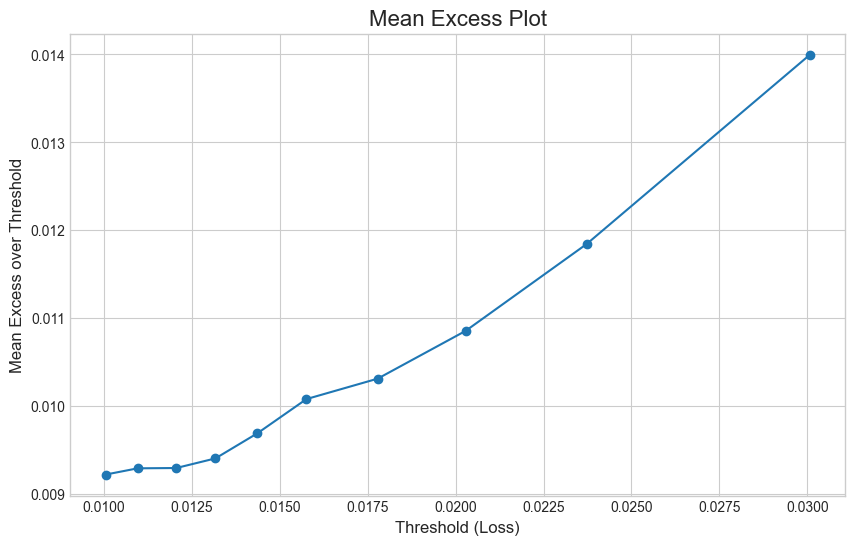


--- EVT-GPD Model Fit (at 1.58% threshold) ---
Estimated Shape parameter (xi): 0.1571
Estimated Scale parameter (beta): 0.0085

99% VaR Estimate (EVT): -3.1353%
97.5% ES Estimate (EVT): -3.3256%


In [16]:
import pandas as pd
import numpy as np
import os
from arch import arch_model
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# --- 1. Define Constants and Load Core Data ---
DATA_DIR = "data"
WINDOW = 252
returns_df = pd.read_csv(
    os.path.join(DATA_DIR, "portfolio_log_returns.csv"),
    index_col='Date',
    parse_dates=True
)
portfolio_returns = returns_df['EqualWeightPortfolio']
print("✅ 1/3: Portfolio returns loaded.")

# --- Generate the GJR-GARCH VaR Series ---
def fit_gjr_garch_model(returns_window):
    try:
        model = arch_model(
            returns_window * 100, vol='Garch', p=1, o=1, q=1,
            mean='Constant', dist='t'
        )
        fit = model.fit(disp='off')
        if not fit.convergence_flag: return fit, True
        else: return None, False
    except Exception: return None, False

gjr_results = []
gjr_dates = []
for i in tqdm(range(WINDOW, len(portfolio_returns)), desc="Calculating Rolling GJR-GARCH VaR"):
    window = portfolio_returns.iloc[i-WINDOW:i]
    current_date = portfolio_returns.index[i]
    gjr_garch_fit, success = fit_gjr_garch_model(window)
    if success:
        forecast = gjr_garch_fit.forecast(horizon=1)
        cond_mean = forecast.mean.iloc[-1, 0] / 100
        cond_vol = np.sqrt(forecast.variance.iloc[-1, 0]) / 100
        std_resid = gjr_garch_fit.resid / gjr_garch_fit.conditional_volatility
        q = std_resid.quantile(0.01)
        var_99 = cond_mean + cond_vol * q
    else:
        var_99 = window.quantile(0.01) # Fallback
    gjr_results.append(var_99)
    gjr_dates.append(current_date)

gjr_garch_var_99 = pd.Series(gjr_results, index=gjr_dates, name='GJR_GARCH_VaR_99')
print("\n✅ Step 1 complete: Rolling GJR-GARCH VaR series created.")

from scipy.stats import genpareto

# --- 1. Setup for EVT ---
# We will apply EVT to the historical portfolio returns
# portfolio_returns should be in memory

# We analyze losses, so we'll use the negative of the returns
losses = -portfolio_returns.dropna()

# --- 2. Justify Threshold with a Mean Excess Plot ---
# A Mean Excess Plot helps identify a suitable threshold for the GPD.
# We look for a region where the plot is roughly linear.
from statsmodels.graphics.gofplots import qqplot

# For simplicity in visualization, we can use a practical approach
# by plotting mean excess over a range of thresholds.
thresholds = losses.quantile(np.linspace(0.90, 0.99, 10))
mean_excess = [losses[losses > t].mean() - t for t in thresholds]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, mean_excess, 'o-')
ax.set_title('Mean Excess Plot', fontsize=16)
ax.set_xlabel('Threshold (Loss)', fontsize=12)
ax.set_ylabel('Mean Excess over Threshold', fontsize=12)
plt.show()

# --- 3. Fit the Generalized Pareto Distribution (GPD) ---
# Based on the plot, we'll select a threshold. Let's start with the 95th percentile.
threshold = losses.quantile(0.95)
exceedances = losses[losses > threshold] - threshold

# Fit the GPD to the exceedances
shape, loc, scale = genpareto.fit(exceedances, floc=0) # floc=0 sets the location parameter to 0

print(f"\n--- EVT-GPD Model Fit (at {threshold*100:.2f}% threshold) ---")
print(f"Estimated Shape parameter (xi): {shape:.4f}")
print(f"Estimated Scale parameter (beta): {scale:.4f}")

# (Keep all your setup and GPD fitting code the same)
# ...

# --- 4. Calculate VaR and ES using the fitted GPD (Definitive Correction) ---
n = len(losses)
n_u = len(exceedances)
phi_u = n_u / n
# Define alphas for both VaR and ES
alpha_var = 0.01   # For 99% VaR
alpha_es = 0.025  # For 97.5% ES

# --- THE FIX: Use the standard, correct formulas ---

# VaR calculation for 99%
evt_var_99 = threshold + (scale / shape) * ( (n / n_u * (1 - (1-alpha_var)))**(-shape) - 1)

# ES calculation for 97.5%
# First, calculate the 97.5% VaR threshold needed for the ES formula
var_975_for_es = threshold + (scale / shape) * ( (n / n_u * (1 - (1-alpha_es)))**(-shape) - 1)
# Then, use the standard formula for GPD ES
evt_es_975 = (var_975_for_es + scale - shape * threshold) / (1 - shape)

# Convert both to negative numbers to represent losses
evt_var_99 = -evt_var_99
evt_es_975 = -evt_es_975


print(f"\n99% VaR Estimate (EVT): {evt_var_99*100:.4f}%")
print(f"97.5% ES Estimate (EVT): {evt_es_975*100:.4f}%")


✅ Final Hybrid HMM ES calculation complete.
Preview:
2008-04-11   -0.026253
2008-04-14   -0.039130
2008-04-15   -0.037879
2008-04-16   -0.036505
2008-04-17   -0.035546
Name: Hybrid_ES_97.5, dtype: float64


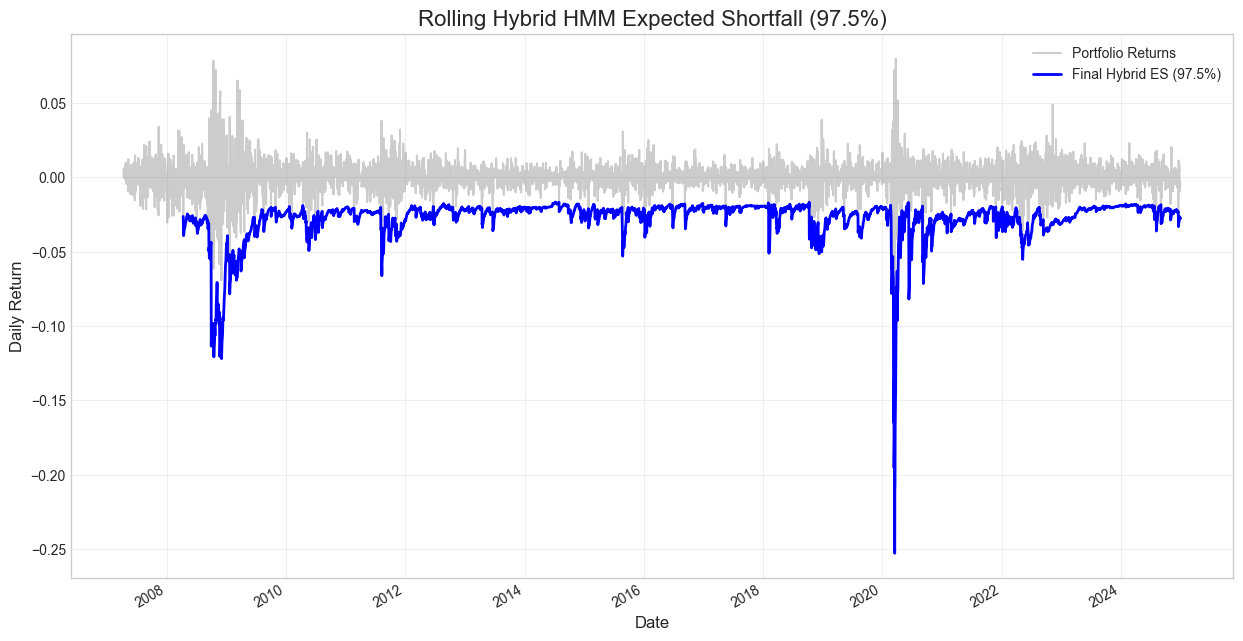


--- Sub-step 1 Complete: All ES series collected ---
            Historical_ES  Parametric_T_ES    GJR_ES  EVT_ES_Static  \
2008-04-11       -0.02703        -0.028725 -0.024504      -0.033256   
2008-04-14       -0.02703        -0.028629 -0.040598      -0.033256   
2008-04-15       -0.02703        -0.028654 -0.039035      -0.033256   
2008-04-16       -0.02703        -0.028669 -0.037317      -0.033256   
2008-04-17       -0.02703        -0.028689 -0.036118      -0.033256   

            Hybrid_HMM_ES  
2008-04-11      -0.026253  
2008-04-14      -0.039130  
2008-04-15      -0.037879  
2008-04-16      -0.036505  
2008-04-17      -0.035546  


In [18]:
import pandas as pd
import numpy as np
import os
from scipy.stats import genpareto, t
from arch import arch_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



calm_weight = 0.65
nervous_weight = 0.80
volatile_weight = 0.90
crisis_weight = 1.00

# Get regime indices sorted by volatility
volatilities = final_hmm_model.means_[:, 1]
regime_order = np.argsort(volatilities)
calm_idx, nervous_idx, volatile_idx, crisis_idx = regime_order

gjr_weights = np.zeros(4)
gjr_weights[calm_idx] = calm_weight
gjr_weights[nervous_idx] = nervous_weight
gjr_weights[volatile_idx] = volatile_weight
gjr_weights[crisis_idx] = crisis_weight

# --- 3. Build the Hybrid ES Model ---
# Create the ES estimate for each of the 4 regimes
es_regime_0 = (1 - gjr_weights[0]) * evt_es_static + gjr_weights[0] * gjr_es_975
es_regime_1 = (1 - gjr_weights[1]) * evt_es_static + gjr_weights[1] * gjr_es_975
es_regime_2 = (1 - gjr_weights[2]) * evt_es_static + gjr_weights[2] * gjr_es_975
es_regime_3 = (1 - gjr_weights[3]) * evt_es_static + gjr_weights[3] * gjr_es_975

# Combine them into a DataFrame
regime_es_df = pd.concat([es_regime_0, es_regime_1, es_regime_2, es_regime_3], axis=1)
regime_es_df.columns = [0, 1, 2, 3]

# Align the daily regime probabilities with the regime ES data
aligned_probs, aligned_regime_es = prob_df.align(regime_es_df, join='inner')

# Calculate the final hybrid ES by taking the weighted average
hybrid_es_values = (aligned_probs * aligned_regime_es).sum(axis=1)
final_hybrid_es_975 = pd.Series(hybrid_es_values, name='Hybrid_ES_97.5')

# Drop any NaNs
final_hybrid_es_975.dropna(inplace=True)

print("\n✅ Final Hybrid HMM ES calculation complete.")
print("Preview:")
print(final_hybrid_es_975.head())

# --- 4. Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

portfolio_returns.plot(ax=ax, color='gray', alpha=0.4, label='Portfolio Returns')
final_hybrid_es_975.plot(ax=ax, color='blue', linewidth=2, label='Final Hybrid ES (97.5%)')

ax.set_title("Rolling Hybrid HMM Expected Shortfall (97.5%)", fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 5. Store All Key ES Series for Next Step ---
# We assume 'hist_es' and 'param_t_es' are also in memory
evt_es_static_series = pd.Series(evt_es_static, index=final_hybrid_es_975.index, name='EVT_ES_97.5_Static')

all_es_series = pd.concat([
    hist_es.rename('Historical_ES'), 
    param_t_es.rename('Parametric_T_ES'), 
    gjr_es_975.rename('GJR_ES'), 
    evt_es_static_series.rename('EVT_ES_Static'), 
    final_hybrid_es_975.rename('Hybrid_HMM_ES')
], axis=1)

all_es_series.dropna(inplace=True)

print("\n--- Sub-step 1 Complete: All ES series collected ---")
print(all_es_series.head())

In [ ]:
es_results_path = os.path.join(DATA_DIR, "phase7_all_es_series.csv")

all_es_series.to_csv(es_results_path)

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import chi2 # Not needed for this step, but good to have
import warnings
warnings.filterwarnings('ignore')

# --- 1. Setup & Load All 99% VaR Data ---
DATA_DIR = "data"
WINDOW = 250 # 250-day window for Basel III backtesting

# Load portfolio returns
returns_df = pd.read_csv(
    os.path.join(DATA_DIR, "portfolio_log_returns.csv"),
    index_col='Date',
    parse_dates=True
)
portfolio_returns = returns_df['EqualWeightPortfolio']

# Load Phase 1 results (for HistVaR_99, ParamVaR_T_99)
phase1_vars = pd.read_csv(
    os.path.join(DATA_DIR, "phase1_all_risk_measures.csv"), 
    index_col='Date', 
    parse_dates=True
)

# Load Phase 3 results (for GJR_GARCH_VaR_99, EVT_VaR_99)
phase3_vars = pd.read_csv(
    os.path.join(DATA_DIR, "phase3_advanced_var_timeseries.csv"), 
    parse_dates=True
)

# Load Phase 4 final hybrid VaR
final_hybrid_var_df = pd.read_csv(
    os.path.join(DATA_DIR, "phase4_final_hybrid_var.csv"),
    index_col=0,
    header=0, 
    names=['Date', 'Hybrid_HMM_VaR']
)
final_hybrid_var_df.index = pd.to_datetime(final_hybrid_var_df.index)
final_hybrid_var = final_hybrid_var_df['Hybrid_HMM_VaR']


# Combine the key 99% VaR models we want to analyze
all_var_series = pd.concat([
    phase1_vars['HistVaR_99'].rename('Historical_VaR'),
    phase1_vars['ParamVaR_T_99'].rename('Parametric_T_VaR'),
    phase3_vars['GJR_GARCH_VaR_99'], # Already has a good name
    phase3_vars['EVT_VaR_99'].rename('EVT_Static_VaR'),
    final_hybrid_var.rename('Hybrid_HMM_VaR') # Use the final calibrated version
], axis=1).dropna()

print("All 99% VaR series loaded.")

# --- 2. Define Basel III Function ---
def get_basel_zone_and_multiplier(breaches):
    """Calculates Basel III zone and capital multiplier."""
    if pd.isna(breaches): return 'Unknown', 3.00
    breaches = int(breaches)
    if breaches <= 4:
        zone, multiplier = 'Green', 3.00
    elif 5 <= breaches <= 9:
        zone = 'Yellow'
        multipliers = {5: 3.40, 6: 3.50, 7: 3.65, 8: 3.75, 9: 3.85}
        multiplier = multipliers[breaches]
    else: # breaches >= 10
        zone, multiplier = 'Red', 4.00
    return zone, multiplier

# Shift all VaR series by 1 day
shifted_vars = all_var_series.shift(1)
aligned_returns, aligned_vars = portfolio_returns.align(shifted_vars, join='inner')

# --- THE FIX: Flip the comparison to be DataFrame-centric ---
# A breach occurs if the return is LESS than the VaR.
# Since VaRs are negative, this is the same as asking if the VaR is GREATER than the return.
# (e.g., VaR of -3% is > Return of -5%)
breaches_df = aligned_vars.gt(aligned_returns, axis=0)
# ---

# Calculate rolling 250-day breach count
rolling_breaches_df = breaches_df.rolling(window=WINDOW, min_periods=WINDOW).sum().dropna()
print(f"\n✅ Rolling 250-day breach counts calculated.")


# --- 4. Apply Basel Function to Get Multipliers ---
capital_multipliers_df = rolling_breaches_df.applymap(lambda x: get_basel_zone_and_multiplier(x)[1])
print(f"\n✅ Rolling capital multipliers (k) calculated.")
print("\n--- Preview of Rolling Capital Multipliers (k) ---")
print(capital_multipliers_df.head())

All 99% VaR series loaded.

✅ Rolling 250-day breach counts calculated.

✅ Rolling capital multipliers (k) calculated.

--- Preview of Rolling Capital Multipliers (k) ---
Empty DataFrame
Columns: [Historical_VaR, Parametric_T_VaR, GJR_GARCH_VaR_99, EVT_Static_VaR, Hybrid_HMM_VaR]
Index: []
